# Monthly DFM

In this notebook, I test the capabilities of Chad Fulton's [code](https://github.com/ChadFulton/tsa-notebooks/blob/master/statespace_large_dynamic_factor_models.ipynb), which estimates a monthly dynamic factor model. I apply it to a German dataset consisting of 18 monthly economic indicators, 10 financial variables, 8 survey series, and one quarterly variable (GDP growth, consumption growth, or investment growth). The goal is to forecast the quarterly variable.

In [1]:
%matplotlib inline

import types
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

- Load monthly (36 variables) and quarterly (1 variable) economic and financial indicators.
- Apply transformations to ensure stationarity of the data.

In [2]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1
    
    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 3:
        column = np.log(column).diff() * 100 * mult
        
    return column

In [3]:
def load_data(vintage, q_var):
    
    # - Monthly data --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'../data/vintages_monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.date.tolist(), freq='M')
    orig_m.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # - Quarterly data --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'../data/vintages_quarterly/{vintage}.csv')
                .dropna(how='all'))
    # Keep the quarterly variable that will be forecasted
    orig_q = orig_q[['date', q_var]]

    # 2. Extract transformation information
    transform_q = orig_q.iloc[0, 1:]
    orig_q = orig_q.iloc[1:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.date.tolist(), freq='Q')
    orig_q.drop('date', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q)

* Load seven vintages: 2008-01-01 (all data available up to 31 Dec 2007; forecast made on 1 Jan 2008), 2008-01-16, 2008-02-01, 2008-02-16, 2008-03-01, 2008-03-16, and 2008-04-01.

In [4]:
# Load the vintages of data
q_var = 'GDP'
dta = {date: load_data(date, q_var = q_var)
       for date in ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']}

In [5]:
# Print some information about the base dataset
n, k = dta['2008-01-01'].dta_m.shape
start = dta['2008-01-01'].dta_m.index[0]
end = dta['2008-01-01'].dta_m.index[-1]

print(f'For vintage 2008-01-01, there are {k} series and {n} observations,'
      f' over the period {start} to {end}.')

For vintage 2008-01-01, there are 36 series and 204 observations, over the period 1991-01 to 2007-12.


* Effect of transformations on the variables (visualization)

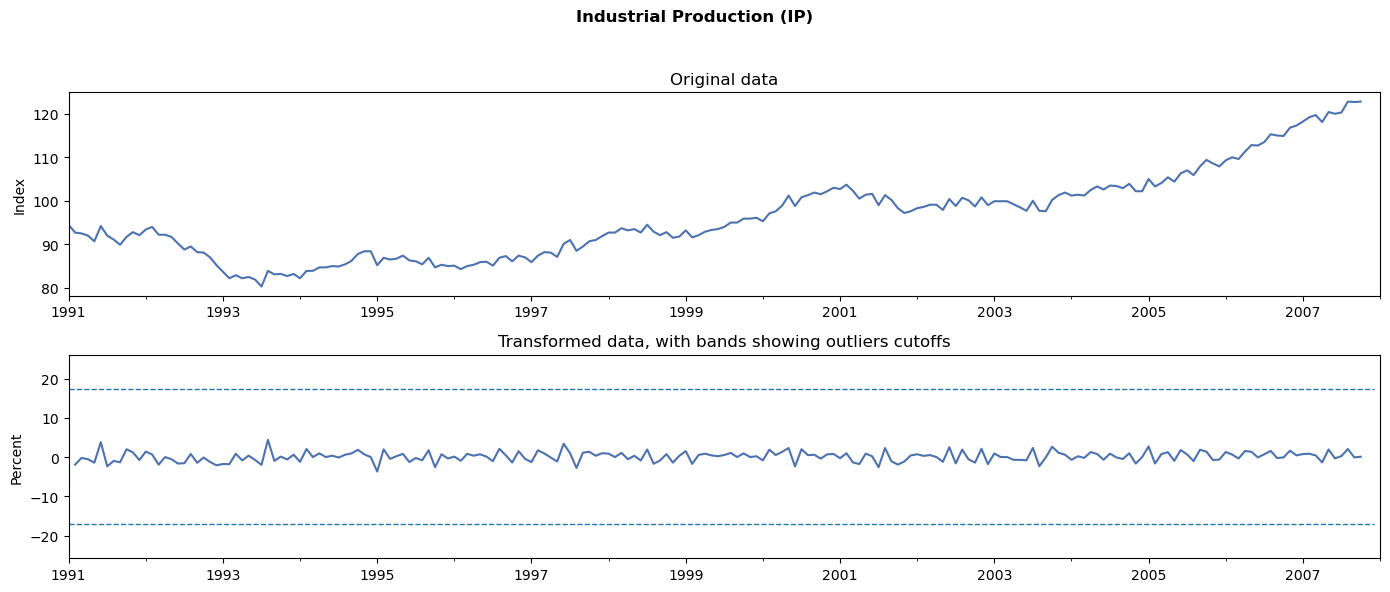

In [6]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(2, figsize=(14, 6))

    # Plot the raw data from the 01-Jan 2008 vintage, for:
    # 
    vintage = '2008-01-01'
    variable = 'IP'
    start = '1991-01'
    end = '2007-12'

    # 1. Plot the original dataset, for 1991-01 through 2007-12
    dta[vintage].orig_m.loc[start:end, variable].plot(ax=axes[0])
    axes[0].set(title='Original data', xlim=('1991','2008'), ylabel='Index')

    # 2. Plot the transformed data
    transformed = transform(dta[vintage].orig_m[variable],
                            dta[vintage].transform_m)
    transformed.loc[start:end].plot(ax=axes[1])
    mean = transformed.mean()
    iqr = transformed.quantile([0.25, 0.75]).diff().iloc[1]
    axes[1].hlines([mean - 10 * iqr, mean + 10 * iqr],
                   transformed.index[0], transformed.index[-1],
                   linestyles='--', linewidth=1)
    axes[1].set(title='Transformed data, with bands showing outliers cutoffs',
                xlim=('1991','2008'), ylim=(mean - 15 * iqr, mean + 15 * iqr),
                ylabel='Percent')
    
    fig.suptitle('Industrial Production (IP)',
                 fontsize=12, fontweight=600)

    fig.tight_layout(rect=[0, 0.00, 1, 0.95]);

* Load definitions with full names of the variables and their groups (Activity, Labor market, Prices, Financial, and Surveys)

In [7]:
# Load the definitions Excel file for monthly variables
defn_m = pd.read_excel('../data/data_monthly/variables_definitions.xlsx')
# Set the index to the "Mnemonic" column
defn_m.index = defn_m['Mnemonic']

# Load the definitions Excel file for quarterly variables
defn_q = pd.read_excel('../data/data_quarterly/variables_definitions.xlsx')
defn_q = defn_q[defn_q.Mnemonic == q_var]
defn_q.index = defn_q.Mnemonic

# Display the first few rows
defn_m.head()

,Mnemonic,Description,Group
Mnemonic,,,
ConstrProd,ConstrProd,Production in main construction industry,Activity
IP,IP,Industrial production index,Activity
ConstrNO,ConstrNO,New orders for main construction industry,Activity
INO,INO,New orders for industry,Activity
ConstrTurn,ConstrTurn,Main construction industry turnover,Activity


* Rename variables in the transformed monthly and quarterly datasets (full names)

In [8]:
# Replace the names of the columns in each monthly and quarterly dataset
map_m = defn_m['Description'].to_dict()
map_q = defn_q['Description'].to_dict()
for date, value in dta.items():
    value.orig_m.columns = value.orig_m.columns.map(map_m)
    value.dta_m.columns = value.dta_m.columns.map(map_m)
    value.orig_q.columns = value.orig_q.columns.map(map_q)
    value.dta_q.columns = value.dta_q.columns.map(map_q)

* Dataframe `groups` will contain Mnemonic, Description and Group of each variable

In [9]:
# Get the mapping of variable mnemonic to group name, for monthly variables
groups = defn_m[['Description', 'Group']].copy()

# Re-order the variables according to the definition file
# (which is ordered by group)
columns = [name for name in defn_m['Description']
           if name in dta['2008-01-01'].dta_m.columns]
for date in dta.keys():
    dta[date].dta_m = dta[date].dta_m.reindex(columns, axis=1)

# Add our quarterly variable into the "Activity" group
q_var_description = defn_q.loc[q_var, 'Description']
groups.loc[q_var] = {'Description': q_var_description, 'Group': 'Activity'}

# Display the number of variables in each group
(groups.groupby('Group', sort=False)
       .count()
       .rename({'Description': '# series in group'}, axis=1))

,# series in group
Group,
Activity,8
Prices,6
Labor market,5
Financial,10
Surveys,8


In [10]:
groups

,Description,Group
Mnemonic,,
ConstrProd,Production in main construction industry,Activity
IP,Industrial production index,Activity
ConstrNO,New orders for main construction industry,Activity
INO,New orders for industry,Activity
ConstrTurn,Main construction industry turnover,Activity
ITurn,Industry turnover,Activity
RetTurn,Retail turnover excluding cars,Activity
CPI,Consumer price index,Prices
CPIEN,"Consumer price index, excluding energy",Prices


## Factor specification

**Global factor(s) only**

In [11]:
# Construct the variable => list of factors dictionary
factors = {row['Description']: ['Global']
           for ix, row in groups.iterrows()}

# Check that we have the desired output for "Industrial production index"
print(factors['Industrial production index'])

['Global']


**Global factor(s) and group-specific factors**

In [12]:
# Construct the variable => list of factors dictionary
factors = {row['Description']: ['Global', row['Group']]
           for ix, row in groups.iterrows()}

# Check that we have the desired output for "Industrial production index"
print(factors['Industrial production index'])

['Global', 'Activity']


**Global factor(s) and labor market factor**

In [13]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Labor market':
        factors[desc] = ['Global', 'Labor market']
    else:
        factors[desc] = ['Global']

**Global factors(s) and prices factor**

In [14]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Prices':
        factors[desc] = ['Global', 'Prices']
    else:
        factors[desc] = ['Global']

**Global factors(s) and financial factor**

In [15]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Financial':
        factors[desc] = ['Global', 'Financial']
    else:
        factors[desc] = ['Global']

**Global factors(s) and surveys factor**

In [16]:
factors = {}
for ix, row in groups.iterrows():
    desc = row['Description']
    if row['Group'] == 'Surveys':
        factors[desc] = ['Global', 'Surveys']
    else:
        factors[desc] = ['Global']

In [17]:
factors

{'Production in main construction industry': ['Global'],
 'Industrial production index': ['Global'],
 'New orders for main construction industry': ['Global'],
 'New orders for industry': ['Global'],
 'Main construction industry turnover': ['Global'],
 'Industry turnover': ['Global'],
 'Retail turnover excluding cars': ['Global'],
 'Consumer price index': ['Global'],
 'Consumer price index, excluding energy': ['Global'],
 'Producer price index': ['Global'],
 'Producer price index, excluding energy': ['Global'],
 'Export price index': ['Global'],
 'Import price index': ['Global'],
 'Hours worked: manufacturing': ['Global'],
 'Hours worked: construction': ['Global'],
 'Employment': ['Global'],
 'Gross wages and salaries: manufacturing and mining': ['Global'],
 'Gross wages and salaries: construction': ['Global'],
 'CDAX': ['Global'],
 'Government bond yields (1-year)': ['Global'],
 'Government bond yields (5-years)': ['Global'],
 'Government bond yields (10-years)': ['Global'],
 'Nominal 

## Number of factors from each group

**Two global factors that evolve together jointly**

In [18]:
factor_multiplicities = {'Global': 2}

## Factor orders

**Two global factors jointly follow VAR(3)**

In [19]:
factor_orders = {'Global': 3}

## The model

* monthly/quarterly mixed frequency model
* AR(1) process for the idiosyncratic disturbance term
* data is standardized

In [20]:
# Get monthly and quarterly datasets
start = '1991-02'
endog_m = dta['2008-01-01'].dta_m.loc[start:, :]
q_var_description = defn_q.loc[q_var, 'Description']
endog_q = dta['2008-01-01'].dta_q.loc[start:, [q_var_description]]

# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog_m, endog_quarterly=endog_q,
    factors=factors, factor_orders=factor_orders,
    factor_multiplicities=factor_multiplicities)

In [21]:
model.summary()

Model:,Dynamic Factor Model,# of monthly variables:,36
,+ 3 factors in 2 blocks,# of quarterly variables:,1
,+ Mixed frequency (M/Q),# of factor blocks:,2
,+ AR(1) idiosyncratic,Idiosyncratic disturbances:,AR(1)
Sample:,1991-02,Standardize variables:,True
,- 2007-12,,
Dep. variable,Global.1,Global.2,Surveys
Production in main const...,X,X,
Industrial production in...,X,X,
New orders for main cons...,X,X,
New orders for industry,X,X,


**Estimation**

In [22]:
results = model.fit(disp=10)

EM start iterations, llf=-8631.8
EM iteration 10, llf=-8486.2, convergence criterion=4.6608e-05
EM iteration 20, llf=-8484, convergence criterion=1.5913e-05
EM iteration 30, llf=-8483.1, convergence criterion=7.5927e-06
EM iteration 40, llf=-8482.6, convergence criterion=4.7828e-06
EM iteration 50, llf=-8482.2, convergence criterion=3.5743e-06
EM iteration 60, llf=-8482, convergence criterion=2.9257e-06
EM iteration 70, llf=-8481.7, convergence criterion=2.5136e-06
EM iteration 80, llf=-8481.5, convergence criterion=2.2201e-06
EM iteration 90, llf=-8481.4, convergence criterion=1.9954e-06
EM iteration 100, llf=-8481.2, convergence criterion=1.8152e-06
EM iteration 110, llf=-8481, convergence criterion=1.666e-06
EM iteration 120, llf=-8480.9, convergence criterion=1.5398e-06
EM iteration 130, llf=-8480.8, convergence criterion=1.4308e-06
EM iteration 140, llf=-8480.7, convergence criterion=1.3356e-06
EM iteration 150, llf=-8480.6, convergence criterion=1.2512e-06
EM iteration 160, llf=-

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        Dynamic Factor Results                                        
======================================================================================================
Dep. Variable:     "Production in main const...", and 36 more   No. Observations:                  203
Model:                                   Dynamic Factor Model   Log Likelihood               -8480.185
                                      + 3 factors in 2 blocks   AIC                          17306.370
                                      + Mixed frequency (M/Q)   BIC                          17879.555
                                        + AR(1) idiosyncratic   HQIC                         17538.258
Date:                                        Tue, 25 Mar 2025   EM Iterations                      189
Time:                                                11:30:45                                         
Sample:                                            02-28-1991                                         
                                                 - 12-31-2007                                         
Covariance Type:                                 Not computed                                         
                                     Observation equation:                                      
================================================================================================
           Factor loadings:   Global.1   Global.2    Surveys    idiosyncratic: AR(1)        var.
------------------------------------------------------------------------------------------------
Production in main const...      -0.05       0.15          .                   -0.31        0.71
Industrial production in...      -0.12       0.24          .                   -0.44        0.48
New orders for main cons...       0.01       0.04          .                   -0.42        0.84
    New orders for industry      -0.12       0.11          .                   -0.46        0.68
Main construction indust...      -0.08       0.14          .                    0.02        0.87
          Industry turnover      -0.14       0.21          .                   -0.48        0.46
Retail turnover excludin...      -0.07       0.08          .                   -0.48        0.76
       Consumer price index      -0.01       0.02          .                    0.11        0.98
Consumer price index, ex...       0.03      -0.02          .                    0.06        0.98
       Producer price index      -0.15       0.10          .                    0.18        0.83
Producer price index, ex...      -0.12       0.08          .                    0.32        0.78
         Export price index      -0.21       0.11          .                    0.30        0.64
         Import price index      -0.18       0.10          .                    0.31        0.72
Hours worked: manufactur...      -0.07       0.17          .                   -0.32        0.72
Hours worked: constructi...      -0.05       0.15          .                   -0.33        0.72
                 Employment      -0.13       0.03          .                    0.49        0.64
Gross wages and salaries...      -0.03       0.02          .                   -0.36        0.87
Gross wages and salaries...      -0.05       0.08          .                   -0.10        0.93
                       CDAX      -0.07       0.10          .                    0.03        0.96
Government bond yields (...      -0.29      -0.09          .                   -0.08        0.52
Government bond yields (...      -0.30      -0.16          .                   -0.41        0.38
Government bond yields (...      -0.26      -0.19          .                   -0.36        0.49
Nominal effective exchan...       0.11      -0.10          .                    0.37        0.78
Nominal effective exchan...       0.12      -0.10          .                    0.38        0.76


## Estimated factors

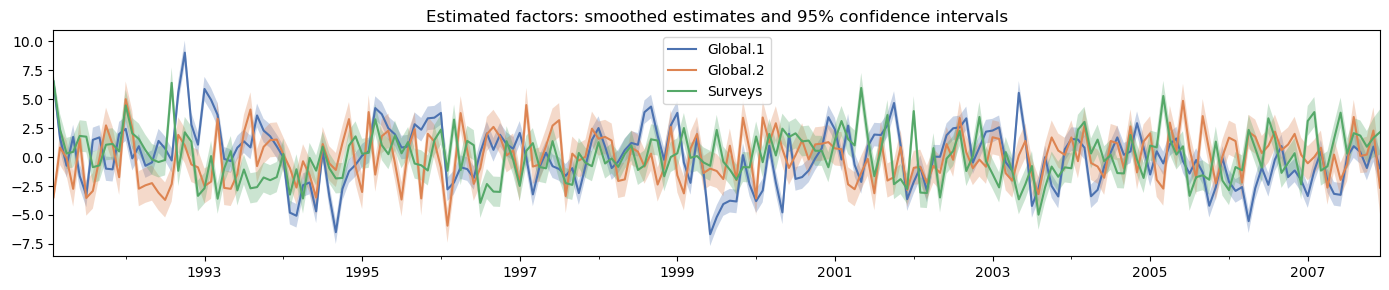

In [24]:
# Get estimates of the global and surveys factors,
# conditional on the full dataset ("smoothed")
factor_names = ['Global.1', 'Global.2', 'Surveys']
mean = results.factors.smoothed[factor_names]

# Compute 95% confidence intervals
from scipy.stats import norm
var = pd.concat([results.factors.smoothed_cov.loc[name, name]
                for name in factor_names], axis=1)
std = np.sqrt(var)

crit = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std

with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 3))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)
    
    ax.set(title='Estimated factors: smoothed estimates and 95% confidence intervals')
    fig.tight_layout();

## Explanatory power of the factors

* The first factor is mainly driven by financial variables, the export price index, and key ifo indicators.
* The second global factor captures activity measures—such as production and turnover—as well as labor market data, ifo indicators, and some financial variables.
* The Surveys factor exclusively loads on survey variables and effectively explains variations in both ifo indicators and the ESI.

In [25]:
rsquared = results.get_coefficients_of_determination(method='individual')

top_ten = []
for factor_name in rsquared.columns[:3]:
    top_factor = (rsquared[factor_name].sort_values(ascending=False)
                                       .iloc[:10].round(2).reset_index())
    top_factor.columns = pd.MultiIndex.from_product([
        [f'Top ten variables explained by {factor_name}'],
        ['Variable', r'$R^2$']])
    top_ten.append(top_factor)
pd.concat(top_ten, axis=1)

Top ten variables explained by Global.1        \
                                        Variable $R^2$   
0  Yields on debt securities issued by residents  0.78   
1                 Yields on bank debt securities  0.78   
2               Yields on public debt securities  0.75   
3               Government bond yields (5-years)  0.53   
4                Government bond yields (1-year)  0.49   
5              Government bond yields (10-years)  0.39   
6            Yields on corporate debt securities  0.28   
7                             Export price index  0.24   
8               ifo: industry and trade, climate  0.24   
9     ifo: industry and trade, current situation  0.19   

         Top ten variables explained by Global.2        \
                                        Variable $R^2$   
0                    Industrial production index  0.32   
1               Yields on public debt securities  0.31   
2  Yields on debt securities issued by residents  0.30   
3                              Industry turnover  0.27   
4                 Yields on bank debt securities  0.27   
5                    Hours worked: manufacturing  0.17   
6     ifo: industry and trade, current situation  0.14   
7              Government bond yields (10-years)  0.12   
8       Production in main construction industry  0.12   
9                     Hours worked: construction  0.12   

       Top ten variables explained by Surveys        
                                     Variable $R^2$  
0            ifo: industry and trade, climate  0.56  
1       ifo: industry and trade, expectations  0.54  
2  ifo: industry and trade, current situation  0.26  
3               Economics Sentiment Indicator  0.19  
4            GfK: business cycle expectations  0.04  
5                      GfK: willigness-to-buy  0.02  
6             GfK: consumer climate indicator  0.01  
7                    GfK: income expectations  0.00  
8    Production in main construction industry   NaN  
9                 Industrial production index   NaN

In [26]:
rsquared

,Global.1,Global.2,Surveys
Production in main construction industry,0.034135,0.120169,NaN
Industrial production index,0.104917,0.318935,NaN
New orders for main construction industry,0.000879,0.001623,NaN
New orders for industry,0.093964,0.049847,NaN
Main construction industry turnover,0.042191,0.090007,NaN
Industry turnover,0.155053,0.267770,NaN
Retail turnover excluding cars,0.008414,0.009298,NaN
Consumer price index,0.000119,0.002951,NaN
"Consumer price index, excluding energy",0.010120,0.002315,NaN
Producer price index,0.106118,0.035047,NaN


## Plotting R^2

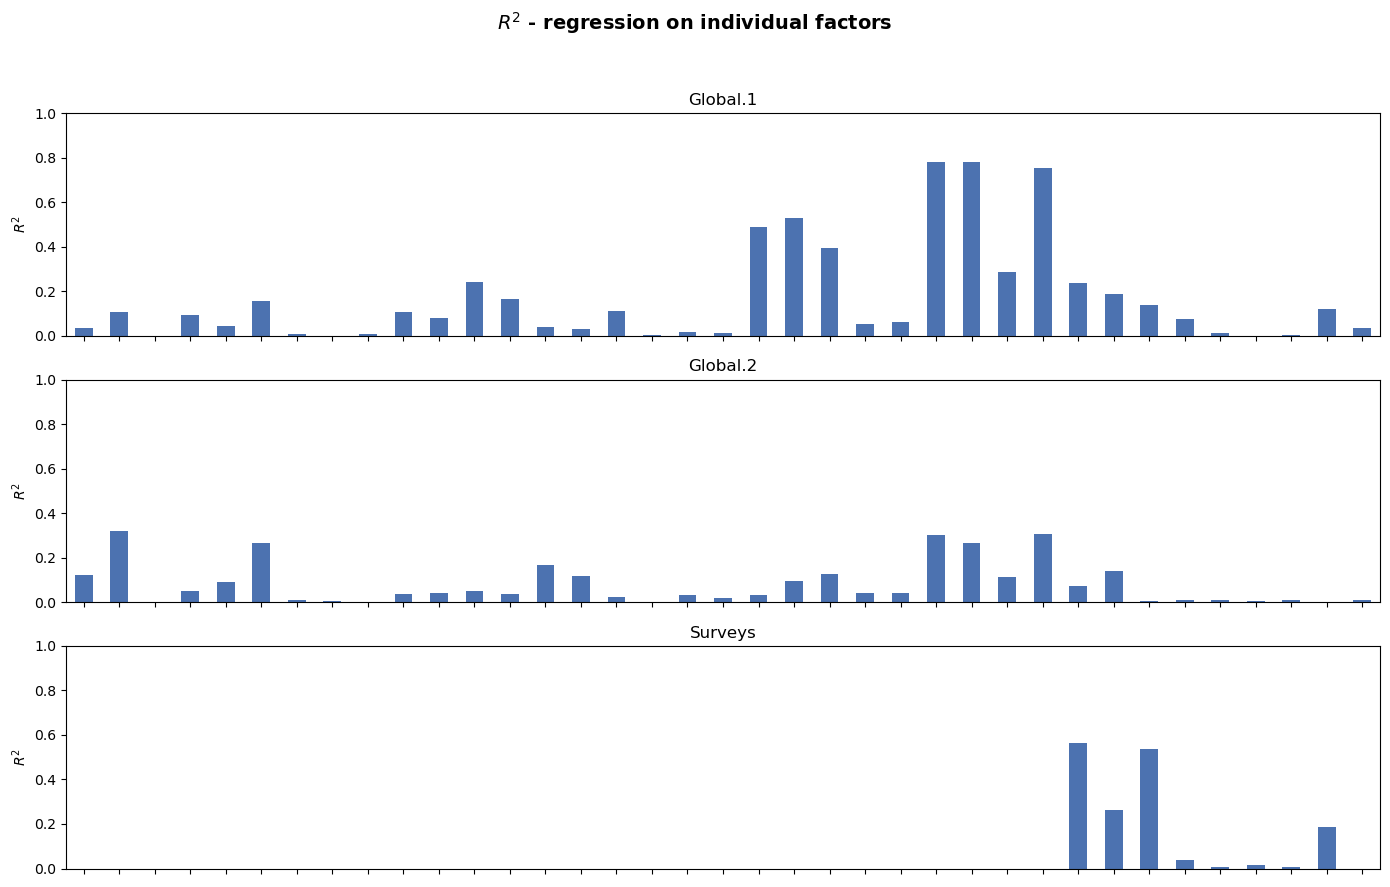

In [27]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(14, 9))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=14, fontweight=600)
    fig.tight_layout(rect=[0, 0, 1, 0.95]);

**Explanatory value of all factors to a given variable**

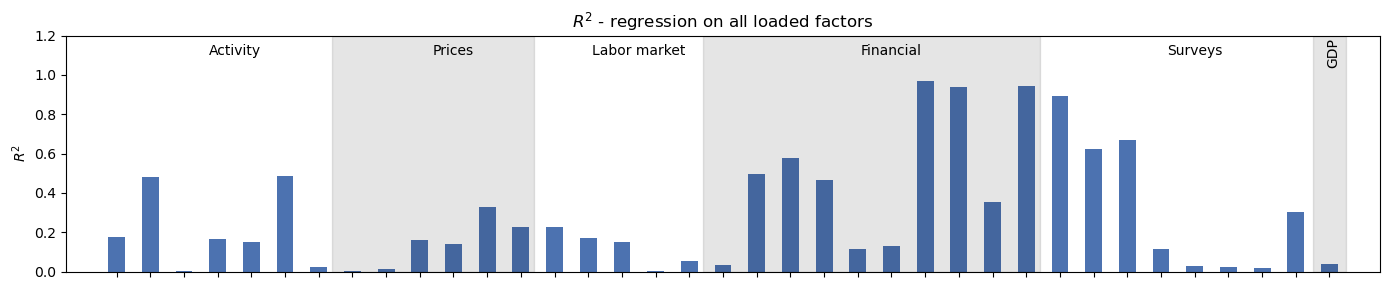

In [28]:
group_counts = defn_m[['Description', 'Group']]
group_counts = group_counts[group_counts['Description'].isin(dta['2008-01-01'].dta_m.columns)]
group_counts = group_counts.groupby('Group', sort=False).count()['Description'].cumsum()

with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='joint', figsize=(14, 3));

    # Add in group labels
    ax = fig.axes[0]
    ax.set_ylim(0, 1.2)
    for i in np.arange(1, len(group_counts), 2):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i] + 1
        ax.fill_between(np.arange(start, end) - 0.6, 0, 1.2, color='k', alpha=0.1)
    for i in range(len(group_counts)):
        start = 0 if i == 0 else group_counts.iloc[i - 1]
        end = group_counts.iloc[i]
        n = end - start
        text = group_counts.index[i]
        #if len(text) > n:
        #    text = text[:n - 3] + '...'

        ax.annotate(text, (start + n / 2, 1.1), ha='center')

    # Add label for a quarterly variable
    ax.set_xlim(-1.5, model.k_endog + 0.5)
    ax.annotate(q_var, (model.k_endog - 1.1, 1.05), ha='left', rotation=90)
    ax.fill_between(np.arange(model.k_endog-1, model.k_endog+1)-0.5, 0, 1.2, color='k', alpha=0.1)
    
    fig.tight_layout();

## Forecasting

* forecast method -> point forecasts only

In [29]:
# Create point forecasts, 3 steps ahead
point_forecasts = results.forecast(steps=3)

# Print the forecasts for the first 5 observed variables
print(point_forecasts.T.head())

                                            2008-01   2008-02   2008-03
Production in main construction industry   0.079123  0.167409 -0.255124
Industrial production index                0.300514  0.250020  0.074452
New orders for main construction industry -1.760245  0.605372 -0.374428
New orders for industry                    0.204271  0.489992  0.073779
Main construction industry turnover        0.147661  0.010117 -0.517840


In [30]:
# The date of the final forecast
results.forecast('2008-03').T

,2008-01,2008-02,2008-03
Production in main construction industry,0.079123,0.167409,-0.255124
Industrial production index,0.300514,0.250020,0.074452
New orders for main construction industry,-1.760245,0.605372,-0.374428
New orders for industry,0.204271,0.489992,0.073779
Main construction industry turnover,0.147661,0.010117,-0.517840
Industry turnover,0.345714,0.381297,0.158064
Retail turnover excluding cars,0.415645,-0.035257,0.064229
Consumer price index,0.130742,0.170702,0.171403
"Consumer price index, excluding energy",0.148761,0.155261,0.159891
Producer price index,0.206437,0.148026,0.114055


* get_forecast method gives confidence intervals

In [31]:
# point forecast
results.get_forecast('2008-03').predicted_mean[q_var_description]

2008-01    1.728611
2008-02    1.384266
2008-03    1.455751
Freq: M, Name: Gross Domestic Product, dtype: float64

In [32]:
# lower bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['lower ' + q_var_description]]

,lower Gross Domestic Product
2008-01,-2.374658
2008-02,-2.785267
2008-03,-2.794389


In [33]:
# upper bound
results.get_forecast('2008-03').conf_int(alpha=0.05)[['upper '+ q_var_description]]

,upper Gross Domestic Product
2008-01,5.831879
2008-02,5.553798
2008-03,5.705891


* predict and get_prediction are more general => in-sample and out-of-sample forecasts

In [34]:
prediction_results = results.get_prediction(start='1991-02', end='2008-03')

In [35]:
prediction_results.predicted_mean[q_var_description]

1991-02   -1.405690
1991-03   -0.462791
1991-04   -5.900964
1991-05   -0.889596
1991-06   -2.287675
             ...   
2007-11    2.452727
2007-12    2.116745
2008-01    1.728611
2008-02    1.384266
2008-03    1.455751
Freq: M, Name: Gross Domestic Product, Length: 206, dtype: float64

In [36]:
ci = prediction_results.conf_int(alpha=0.05)

In [37]:
ci[['upper ' + q_var_description]]

,upper Gross Domestic Product
1991-02,2.988450
1991-03,3.898971
1991-04,-2.333664
1991-05,3.174018
1991-06,1.675271
...,...
2007-11,5.956114
2007-12,6.163780
2008-01,5.831879
2008-02,5.553798


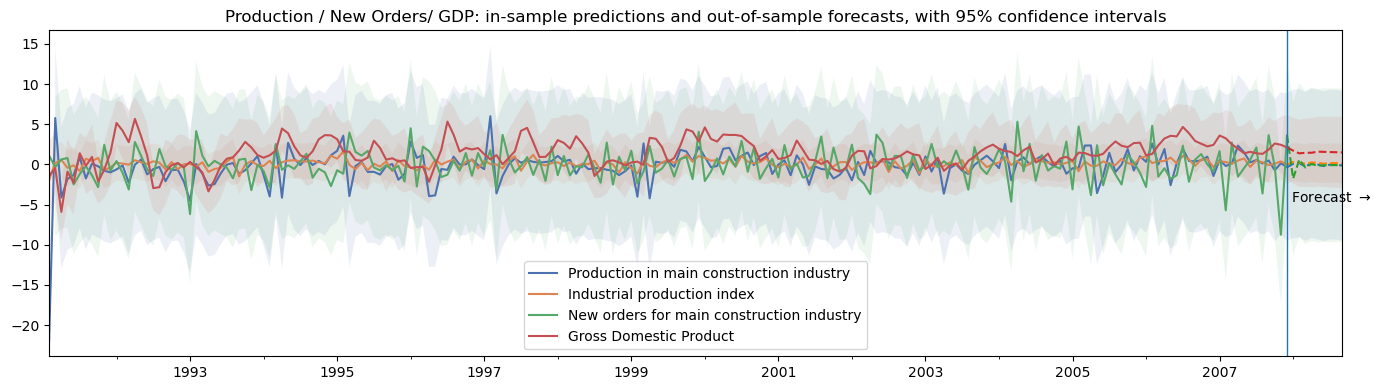

In [38]:
# Create forecasts results objects, through the end of 2008-09
prediction_results = results.get_prediction(start='1991', end='2008-09')

variables = ['Production in main construction industry',
             'Industrial production index',
             'New orders for main construction industry',
             'Gross Domestic Product']

# The `predicted_mean` attribute gives the same
# point forecasts that would have been returned from
# using the `predict` or `forecast` methods.
point_predictions = prediction_results.predicted_mean[variables]

# We can use the `conf_int` method to get confidence
# intervals; here, the 95% confidence interval
ci = prediction_results.conf_int(alpha=0.05)
lower = ci[[f'lower {name}' for name in variables]]
upper = ci[[f'upper {name}' for name in variables]]

# Plot the forecasts and confidence intervals
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 4))

    # Plot the in-sample predictions
    point_predictions.loc[:'2007-12'].plot(ax=ax)

    # Plot the out-of-sample forecasts
    point_predictions.loc['2007-12':].plot(ax=ax, linestyle='--',
                                           color=['C0', 'C1', 'C2', 'C3'],
                                           legend=False)

    # Confidence intervals
    for name in variables:
        ax.fill_between(ci.index,
                        lower[f'lower {name}'],
                        upper[f'upper {name}'], alpha=0.1)
        
    # Forecast period, set title
    ylim = ax.get_ylim()
    ax.vlines('2007-12', ylim[0], ylim[1], linewidth=1)
    ax.annotate(r' Forecast $\rightarrow$', ('2007-12', -4.7))
    ax.set(title=('Production / New Orders/ GDP:'
                  ' in-sample predictions and out-of-sample forecasts, with 95% confidence intervals'), ylim=ylim)
    
    fig.tight_layout()

## GDP forecast

In [39]:
# Compute the point forecasts
#fcast_q = results.forecast('2009-12')[q_var_description].resample('Q').last()
fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[q_var_description].resample('Q').last()

C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_24436\520806084.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  fcast_q = results.get_prediction(start='2007-10', end='2009-12').predicted_mean[q_var_description].resample('Q').last()


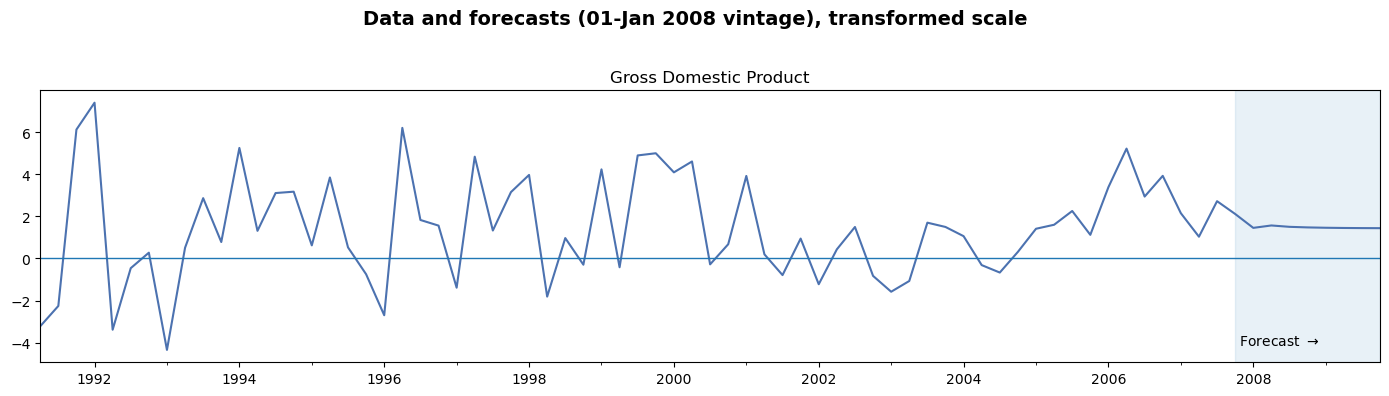

In [40]:
# For more convenient plotting, combine the observed data with the forecasts
plot_q = pd.concat([dta['2008-01-01'].dta_q.loc['1991-04':'2007-09', q_var_description], fcast_q])

with sns.color_palette('deep'):
    fig, axes = plt.subplots(1, figsize=(14, 4))

    # Plot quarterly variable (growth), data and forecasts
    plot_q.plot(ax=axes)
    axes.set(title=q_var_description)
    axes.hlines(0, plot_q.index[0], plot_q.index[-1], linewidth=1)
    
    # Show the forecast period
    ylim = axes.get_ylim()
    axes.fill_between(plot_q.loc['2007-10':].index,
                             ylim[0], ylim[1], alpha=0.1, color='C0')
    axes.annotate(r' Forecast $\rightarrow$',
                         ('2007-10', ylim[0] + 0.1 * ylim[1]))
    axes.set_ylim(ylim)

    # Title
    fig.suptitle('Data and forecasts (01-Jan 2008 vintage), transformed scale',
                 fontsize=14, fontweight=600)

    fig.tight_layout(rect=[0, 0, 1, 0.95]);

## Original GDP forecast (2008-01-01 vintage)

In [41]:
# The original point forecasts are monthly
point_forecasts_m = results.forecast('2008-03')[q_var_description]

# Resample to quarterly frequency by taking the value in the last
# month of each quarter
point_forecasts_q = point_forecasts_m.resample('Q').last()

print('Baseline (1st of January 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of January 2008) forecast for real GDP growth in 2008Q1: 1.46%


C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_24436\646263151.py:6: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  point_forecasts_q = point_forecasts_m.resample('Q').last()


In [42]:
# The original point forecasts are monthly
point_forecasts_m = results.get_prediction(start='2008-03', end='2008-03').predicted_mean[q_var_description]

print('Baseline (1st of January 2008) forecast for real GDP growth'
      f' in 2008Q1: {point_forecasts_q["2008Q1"]:.2f}%')

Baseline (1st of January 2008) forecast for real GDP growth in 2008Q1: 1.46%


## Updated GDP forecast: Jan16 2008 vintage

In [43]:
# Since we will be collecting results for a number of vintages,
# construct a dictionary to hold them, and include the baseline
# results from 01-Jan 2008
vintage_results = {'2008-01-01': results}

# Get the updated monthly and quarterly datasets
start = '1991-02'
updated_endog_m = dta['2008-01-16'].dta_m.loc[start:, :]
q_var_description = defn_q.loc[q_var, 'Description']
updated_endog_q = dta['2008-01-16'].dta_q.loc[start:, [q_var_description]]

# Get the results for Mid Jan 2008 using `apply`
vintage_results['2008-01-16'] = results.apply(
    updated_endog_m, endog_quarterly=updated_endog_q)

In [44]:
# Print the updated forecast for real GDP growth in 2008Q1
updated_forecasts_q = (
    vintage_results['2008-01-16'].forecast('2008-03')[q_var_description]
                              .resample('Q').last())

print('Mid Jan 2008 forecast for real GDP growth in 2008Q1:'
      f' {updated_forecasts_q["2008Q1"]:.2f}%')

Mid Jan 2008 forecast for real GDP growth in 2008Q1: 1.30%


C:\Users\mokuneva\AppData\Local\Temp\2\ipykernel_24436\4218428434.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  vintage_results['2008-01-16'].forecast('2008-03')[q_var_description]


## Updated GDP forecast: 01Jan2008 - 01Apr 2008 vintages

In [45]:
# Apply our results to the remaining vintages
for vintage in ['2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']:
    # Get updated data for the vintage
    updated_endog_m = dta[vintage].dta_m.loc[start:, :]
    updated_endog_q = dta[vintage].dta_q.loc[start:, [q_var_description]]

    # Get updated results for for the vintage
    vintage_results[vintage] = results.apply(
        updated_endog_m, endog_quarterly=updated_endog_q)

In [46]:
# Compute forecasts for each vintage
forecasts = {vintage: res.get_prediction(start='2008-03', end='2008-03').predicted_mean[q_var_description].loc['2008-03']
             for vintage, res in vintage_results.items()}
# Convert to a Pandas series with a date index
forecasts = pd.Series(list(forecasts.values()),
                      index=pd.PeriodIndex(forecasts.keys(), freq='D'))
    
# Print our forecast for 2008Q1 real GDP growth across all vintages
for vintage, value in forecasts.items():
    print(f'{vintage} forecast for real GDP growth in 2008Q1:'
          f' {value:.2f}%')

2008-01-01 forecast for real GDP growth in 2008Q1: 1.46%
2008-01-16 forecast for real GDP growth in 2008Q1: 1.30%
2008-02-01 forecast for real GDP growth in 2008Q1: 1.05%
2008-02-16 forecast for real GDP growth in 2008Q1: 1.28%
2008-03-01 forecast for real GDP growth in 2008Q1: 2.10%
2008-03-16 forecast for real GDP growth in 2008Q1: 2.57%
2008-04-01 forecast for real GDP growth in 2008Q1: 2.99%


## News

In [47]:
# Compute the news and impacts on the real GDP growth forecast
# for 2008Q1, between 2008-01-01 and 2008-01-16 vintages
news = vintage_results['2008-01-16'].news(
    vintage_results['2008-01-01'], impact_date='2008-03',
    impacted_variable=q_var_description,
    comparison_type='previous')

# The `summary` method summarizes all updates. Here we aren't
# showing it, to save space.
news.summary()

X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     0.09
1    -0.90
2    -0.46
3     3.39
4    -0.74
5    -1.33
6    -0.40
Name: observed, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 2:] = data.iloc[:, 2:].map(
X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     0.03
1     0.75
2     0.36
3    -1.03
4     1.95
5     1.42
6    -1.44
Name: forecast (prev), dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.iloc[:, 2:] = data.iloc[:, 2:].map(
X:\conda\envs\nowcasting\lib\site-packages\statsmodels\tsa\statespace\news.py:1328: FutureWarning: Setting an

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      News                                     
===============================================================================
Model:                DynamicFactorMQ   Original sample:                1991-02
Date:                Tue, 25 Mar 2025                                 - 2007-12
Time:                        11:36:57   Update through:                 2007-12
                                        # of revisions:                      67
                                        # of new datapoints:                  7
                 Impacts for [impacted variable = Gross Domestic Product]                 
==========================================================================================
impact date estimate (prev) impact of revisions impact of news total impact estimate (new)
------------------------------------------------------------------------------------------
    2008-03            1.46                0.00          -0.15        -0.15           1.30
                              News from updated observations:                              
===========================================================================================
update date                         updated variable   observed forecast (prev)        news
-------------------------------------------------------------------------------------------
    2007-11                               Employment       0.09            0.03        0.06
                         Industrial production index      -0.90            0.75       -1.65
                                   Industry turnover      -0.46            0.36       -0.81
                             New orders for industry       3.39           -1.03        4.42
            Production in main construction industry      -0.74            1.95       -2.69
                      Retail turnover excluding cars      -1.33            1.42       -2.75
    2007-12            Economics Sentiment Indicator      -0.40           -1.44        1.04
===========================================================================================
"""

In [48]:
# We can re-arrange the `details_by_impact` table to show the new
# observations with the top ten impacts (in absolute value)
details = news.details_by_impact
details.index = details.index.droplevel(['impact date', 'impacted variable'])
details['absolute impact'] = np.abs(details['impact'])
details = (details.sort_values('absolute impact', ascending=False)
                  .drop('absolute impact', axis=1))
details.iloc[:10].round(2)

observed  \
update date updated variable                                     
2007-11     Industrial production index                  -0.90   
            New orders for industry                       3.39   
            Industry turnover                            -0.46   
            Retail turnover excluding cars               -1.33   
            Production in main construction industry     -0.74   
2007-12     Economics Sentiment Indicator                -0.40   
2007-11     Employment                                    0.09   

                                                      forecast (prev)  news  \
update date updated variable                                                  
2007-11     Industrial production index                          0.75 -1.65   
            New orders for industry                             -1.03  4.42   
            Industry turnover                                    0.36 -0.81   
            Retail turnover excluding cars                       1.42 -2.75   
            Production in main construction industry             1.95 -2.69   
2007-12     Economics Sentiment Indicator                       -1.44  1.04   
2007-11     Employment                                           0.03  0.06   

                                                      weight  impact  
update date updated variable                                          
2007-11     Industrial production index                 0.06   -0.11  
            New orders for industry                     0.02    0.07  
            Industry turnover                           0.07   -0.06  
            Retail turnover excluding cars              0.01   -0.04  
            Production in main construction industry    0.01   -0.02  
2007-12     Economics Sentiment Indicator              -0.01   -0.01  
2007-11     Employment                                  0.11    0.01

**All vintages**

In [49]:
news_results = {}
vintages = ['2008-01-01', '2008-01-16', '2008-02-01', '2008-02-16', '2008-03-01', '2008-03-16', '2008-04-01']
impact_date = '2008-03'

for i in range(1, len(vintages)):
    vintage = vintages[i]
    prev_vintage = vintages[i - 1]

    # Notice that to get the "incremental" news, we are computing
    # the news relative to the previous vintage and not to the baseline
    # (2008-01-01) vintage
    news_results[vintage] = vintage_results[vintage].news(
        vintage_results[prev_vintage],
        impact_date=impact_date,
        impacted_variable=q_var_description,
        comparison_type='previous')

In [50]:
news_results['2008-04-01'].details_by_impact

observed  \
impact date impacted variable      update date updated variable                                                   
2008-03     Gross Domestic Product 2008-01     Gross wages and salaries: construction              3.642154e+00   
                                               Gross wages and salaries: manufacturing and mining -5.481455e-02   
                                               Hours worked: construction                          1.055843e+01   
                                               Hours worked: manufacturing                        -9.147848e-01   
                                               Main construction industry turnover                 1.497854e+01   
                                               New orders for main construction industry           1.874745e+01   
                                   2008-02     Export price index                                  4.623217e-01   
                                               Import price index                                  8.920666e-01   
                                               Producer price index                                5.725987e-01   
                                               Producer price index, excluding energy              4.446428e-01   
                                   2008-03     CDAX                                               -3.106678e+00   
                                               Consumer price index                                3.777153e-01   
                                               Economics Sentiment Indicator                      -3.000000e-01   
                                               GfK: business cycle expectations                    4.000000e-01   
                                               GfK: consumer climate indicator                     1.000000e-01   
                                               GfK: income expectations                            2.000000e+00   
                                               GfK: willigness-to-buy                              4.800000e+00   
                                               Government bond yields (1-year)                     2.300000e-01   
                                               Government bond yields (10-years)                   2.000000e-02   
                                               Government bond yields (5-years)                    2.300000e-01   
                                               Nominal effective exchange rate (broad)             2.895329e+00   
                                               Nominal effective exchange rate (narrow)            2.408879e+00   
                                               Yields on bank debt securities                     -3.469447e-18   
                                               Yields on corporate debt securities                -3.000000e-02   
                                               Yields on debt securities issued by residents      -1.000000e-01   
                                               Yields on public debt securities                   -1.000000e-01   
                                               ifo: industry and trade, climate                    1.500000e+00   
                                               ifo: industry and trade, current situation          2.300000e+00   
                                               ifo: industry and trade, expectations               7.000000e-01   

                                                                                                   forecast (prev)  \
impact date impacted variable      update date updated variable                                                      
2008-03     Gross Domestic Product 2008-01     Gross wages and salaries: construction                     1.586457   
                                               Gross wages and salaries: manufacturing and mining         0.127519   
                                               Hours worked: cons

## Impacts by group

In [51]:
group_impacts = {'2008-01-01': None}

for vintage, news in news_results.items():
    # Start from the details by impact table
    details_by_impact = (
        news.details_by_impact.reset_index()
            .drop(['impact date', 'impacted variable'], axis=1))
    
    # Merge with the groups dataset, so that we can identify
    # which group each individual impact belongs to
    impacts = (pd.merge(details_by_impact, groups, how='left',
                        left_on='updated variable', right_on='Description')
                 .drop('Description', axis=1)
                 .set_index(['update date', 'updated variable']))

    # Compute impacts by group, summing across the individual impacts
    group_impacts[vintage] = impacts.groupby('Group').sum()['impact']

# Add in a row of zeros for the baseline forecast
group_impacts['2008-01-01'] = group_impacts['2008-01-16'] * np.nan

# Convert into a Pandas DataFrame, and fill in missing entries
# with zeros (missing entries happen when there were no updates
# for a given group in a given vintage)
group_impacts = (
    pd.concat(group_impacts, axis=1)
      .fillna(0)
      .reindex(group_counts.index).T)
group_impacts.index = forecasts.index

# Print the table of impacts from data in each group,
# along with a row with the "Total" impact
#(group_impacts.T
#    .append(group_impacts.sum(axis=1).rename('Total impact on 2020Q2 forecast'))
#    .round(2).iloc[:, 1:])

pd.concat(
    [
        group_impacts.T,
        group_impacts.sum(axis=1).rename('Total impact on 2008Q1 forecast').to_frame().T
    ],
    axis=0
).round(2).iloc[:, 1:]

,2008-01-16,2008-02-01,2008-02-16,2008-03-01,2008-03-16,2008-04-01
Activity,-0.15,-0.04,0.08,0.03,0.32,0.10
Prices,0.00,-0.00,0.00,0.69,0.01,0.32
Labor market,0.01,-0.01,0.14,0.09,0.00,0.04
Financial,0.00,-0.53,0.00,-0.02,0.00,0.01
Surveys,-0.01,0.33,0.00,0.00,0.00,0.10
Total impact on 2008Q1 forecast,-0.15,-0.25,0.22,0.79,0.32,0.58


**Impacts by group: graphical illustration**

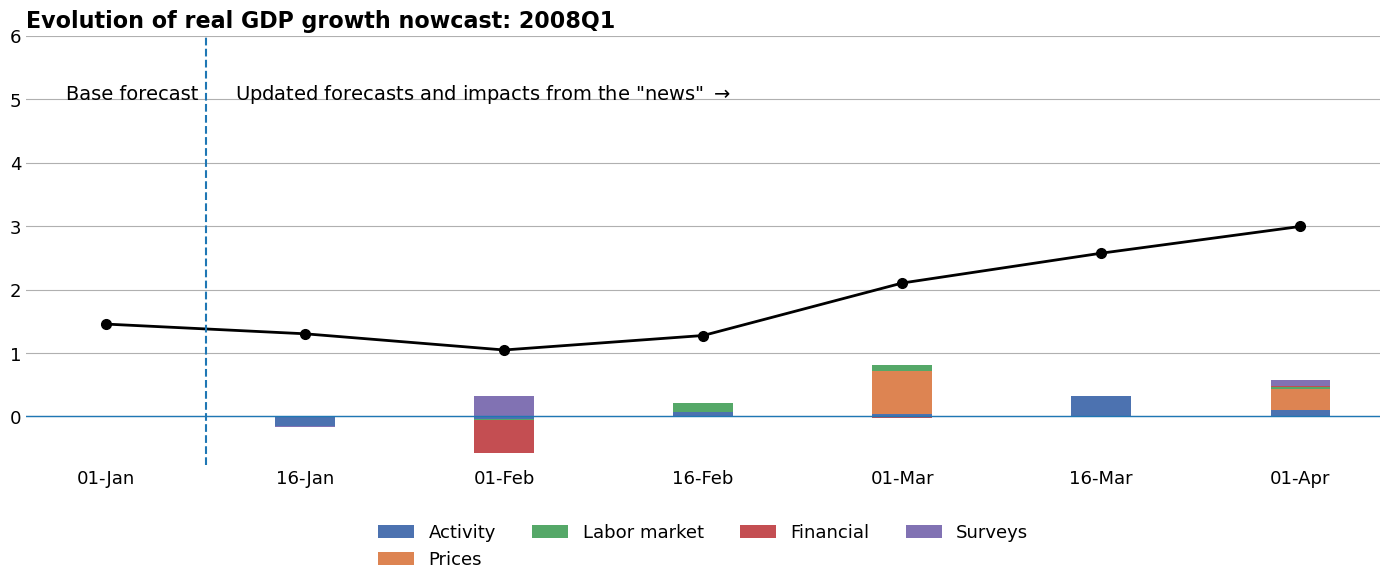

In [52]:
with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(14, 6))

    # Stacked bar plot showing the impacts by group
    group_impacts.plot(kind='bar', stacked=True, width=0.3, zorder=2, ax=ax)

    # Line plot showing the forecast for real GDP growth in 2008Q1 for each vintage
    x = np.arange(len(forecasts))
    ax.plot(x, forecasts, marker='o', color='k', markersize=7, linewidth=2)
    ax.hlines(0, -1, len(group_impacts) + 1, linewidth=1)

    # x-ticks
    labels = group_impacts.index.strftime('%d-%b')
    ax.xaxis.set_ticklabels(labels)
    ax.xaxis.set_tick_params(size=0)
    ax.xaxis.set_tick_params(labelrotation='auto', labelsize=13)
    
    # y-ticks
    ax.set_ylim(top=6)
    ax.yaxis.set_tick_params(direction='in', size=0, labelsize=13)
    ax.yaxis.grid(zorder=0)
    
    # title, remove spines
    ax.set_title('Evolution of real GDP growth nowcast: 2008Q1', fontsize=16, fontweight=600, loc='left')
    [ax.spines[spine].set_visible(False)
     for spine in ['top', 'left', 'bottom', 'right']]

    # base forecast vs updates
    ylim = ax.get_ylim()
    ax.vlines(0.5, ylim[0], ylim[1] + 5, linestyles='--')
    ax.annotate('Base forecast', (-0.2, 5), fontsize=14)
    ax.annotate(r'Updated forecasts and impacts from the "news" $\rightarrow$', (0.65, 5), fontsize=14)

    # legend
    ax.legend(loc='upper center', ncol=4, fontsize=13, bbox_to_anchor=(0.5, -0.1), frameon=False)

    fig.tight_layout()